In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [2]:
df = pd.read_csv("features/features.csv")

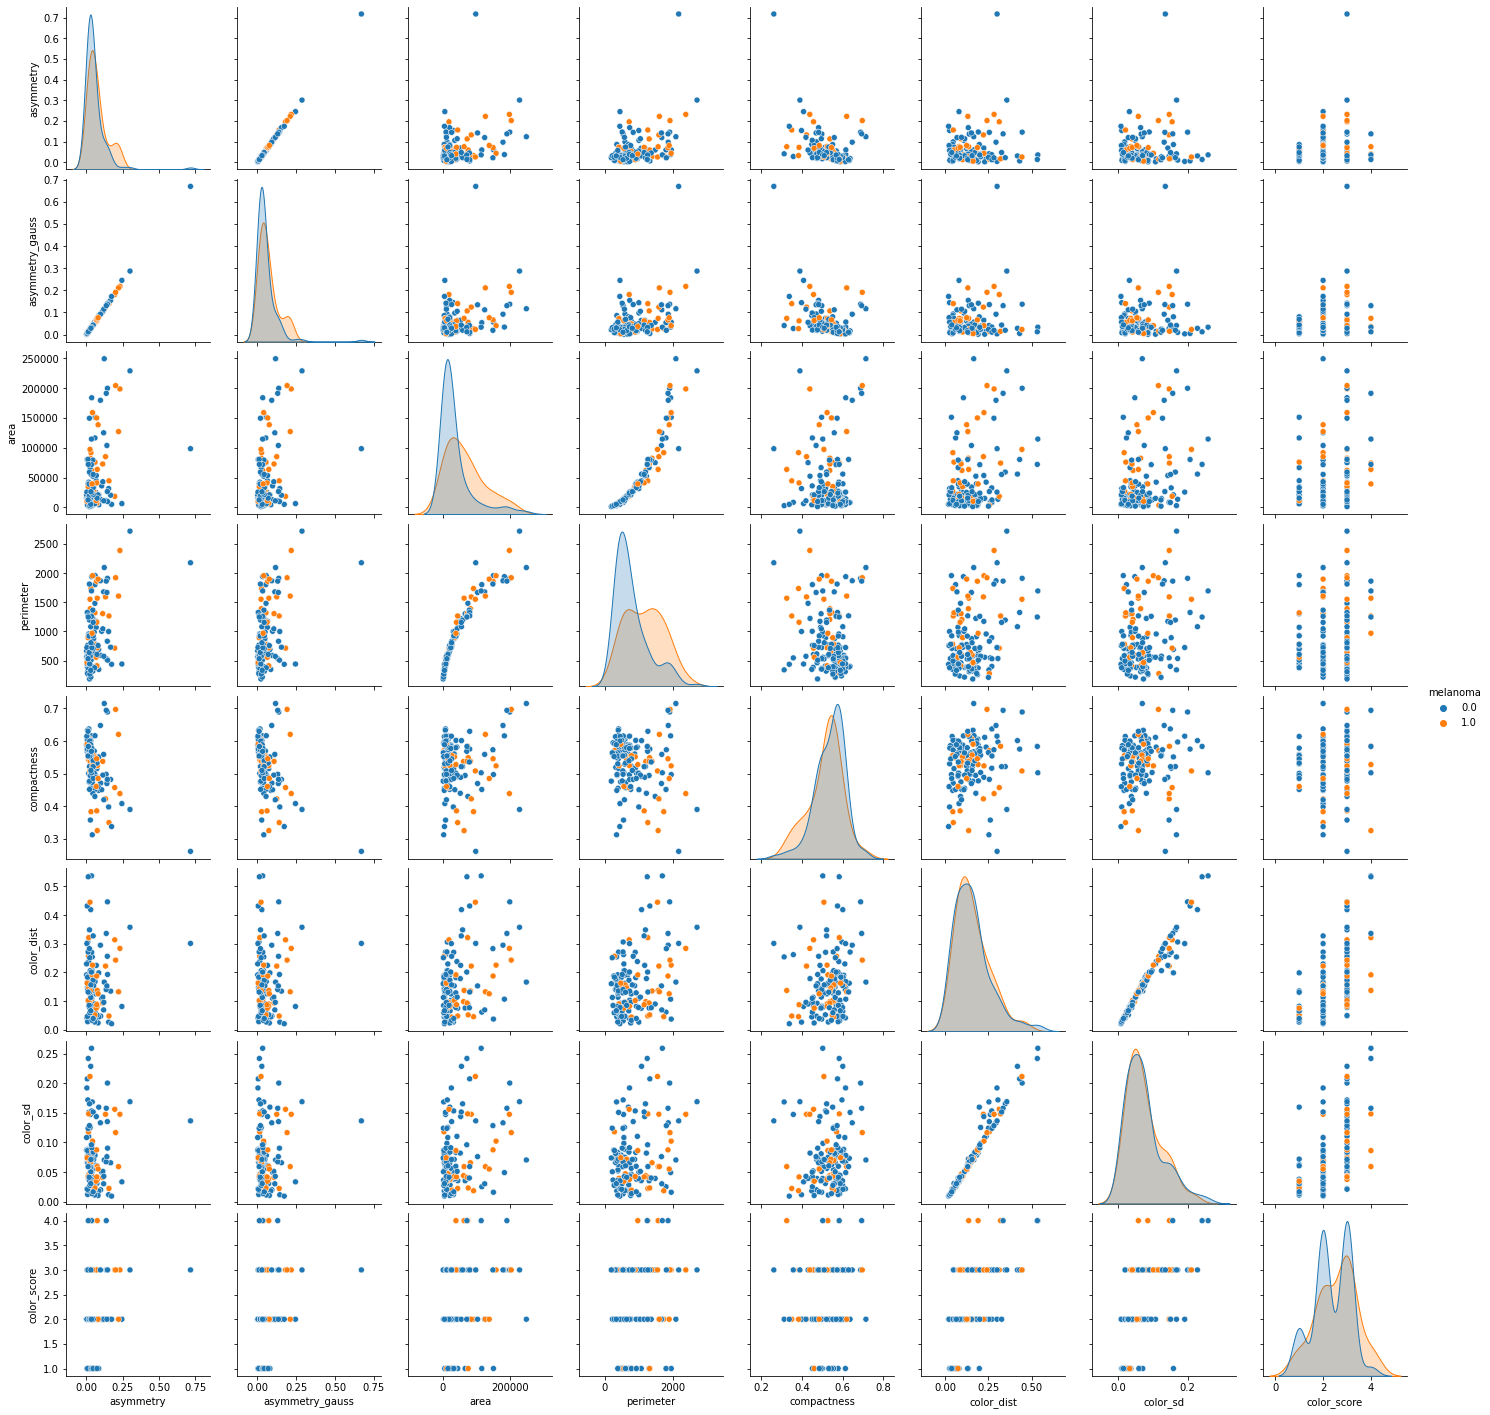

In [3]:
sns.pairplot(data=df, hue="melanoma", diag_kind="kde", diag_kws={"common_norm": False})

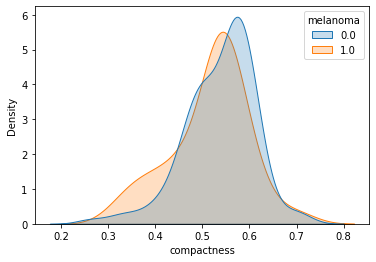

In [4]:
sns.kdeplot("compactness", hue="melanoma", data=df, fill=True, common_norm=False);

In [5]:
pearsonr(df["color_dist"], df["color_sd"])

(0.9791019388601951, 2.828854982062931e-104)

In [20]:
X = df.drop(["image_id", "melanoma"], axis=1)
y = df["melanoma"]
feature_names = [
    "asymmetry",
    "asymmetry_gauss",
    "area",
    "perimeter",
    "compactness",
    "color_dist",
    "color_sd",
    "color_score",
]

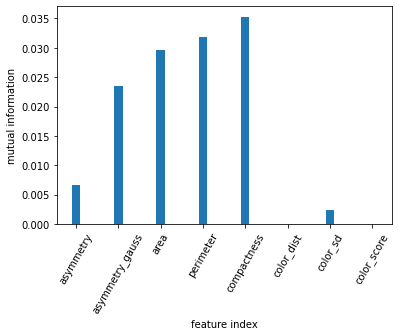

In [24]:
selector = SelectKBest(mutual_info_classif, k=4)
selector.fit(X, y)

# Show the feature scores
scores = selector.scores_


fig, ax = plt.subplots()
ax.bar(feature_names, scores, width=.2)
ax.set_xlabel('feature index')
ax.set_ylabel('mutual information')
plt.xticks(rotation=60);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6840a14b-d41a-45b9-abd0-892354334cb2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>